In [ ]:
# ONLY RUN THIS IF YOU'RE IN GOOGLE COLAB
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Thesis/Pintu-Air')

# Verify you're in the right place
!pwd
!ls -la

Mounted at /content/drive
/content/drive/MyDrive/Thesis/Pintu-Air
total 7562
-rw------- 1 root root 6428389 May 28 22:44 '03 Result Data Cleaning Part 3.csv'
-rw------- 1 root root  317906 May 28 22:44  04a_ARIMA_Katulampa.ipynb
-rw------- 1 root root  250989 May 28 22:44  04c_ARIMA_Manggarai.ipynb
-rw------- 1 root root  708707 May 28 22:44  04e_ARIMA_Pasar_Ikan.ipynb
drwx------ 2 root root    4096 May 28 22:44  .git
-rw------- 1 root root   12122 May 28 22:44  LibrariesFunctions.py
-rw------- 1 root root    3166 May 28 22:44 'model_comparison_Katulampa (air)_results.csv'
-rw------- 1 root root    2636 May 28 22:44 'model_comparison_Manggarai (air)_results.csv'
-rw------- 1 root root    8442 May 28 22:44 'model_comparison_Pasar Ikan (air)_results.csv'
drwx------ 2 root root    4096 May 28 22:44  __pycache__
-rw------- 1 root root      11 May 28 22:44  README.md


In [ ]:
# Import libraries and functions
%run LibrariesFunctions.py
from LibrariesFunctions import *

# Import Data

In [ ]:
data_x_train, data_x_test, data_y_train, data_y_test = read_data('Pasar Ikan')

Full Dataset Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31224 entries, 2021-10-16 00:00:00 to 2025-05-08 23:00:00
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID_Raw                31196 non-null  float64
 1   ID_Cleaned            31224 non-null  int64  
 2   Katulampa (air)       31224 non-null  float64
 3   Katulampa (cuaca)     31224 non-null  object 
 4   Depok (air)           31224 non-null  float64
 5   Depok (cuaca)         31224 non-null  object 
 6   Manggarai (air)       31224 non-null  float64
 7   Manggarai (cuaca)     31224 non-null  object 
 8   Karet (air)           31224 non-null  float64
 9   Karet (cuaca)         31224 non-null  object 
 10  Krukut (air)          31224 non-null  float64
 11  Krukut (cuaca)        31224 non-null  object 
 12  Pesanggrahan (air)    31224 non-null  float64
 13  Pesanggrahan (cuaca)  31224 non-null  object 
 14  Angke (ai

In [ ]:
data_y_train

,Pasar Ikan (air)
Tanggal,
2021-10-16 00:00:00,155.0
2021-10-16 01:00:00,155.0
2021-10-16 02:00:00,155.0
2021-10-16 03:00:00,140.0
2021-10-16 04:00:00,146.0
...,...
2025-03-04 17:00:00,170.0
2025-03-04 18:00:00,165.0
2025-03-04 19:00:00,180.0


# EDA

In [ ]:
period = 24

decomposition = seasonal_decompose(
    data_y_train,
    model='additive',
    period=period,
    extrapolate_trend='freq'
)
plot_decompose(decomposition)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
period = 12

decomposition = seasonal_decompose(
    data_y_train,
    model='additive',
    period=period,
    extrapolate_trend='freq'
)
plot_decompose(decomposition)

Output hidden; open in https://colab.research.google.com to view.

# Uji Stasioneritas

## Uji Stasioneritas terhadap Varians

$$
\begin{aligned}
H_0&: \lambda=1 \text{(Stasioner terhadap varians)}\\H_1&: \lambda\ne1\\
\end{aligned}
$$

In [ ]:
lambda_opt = boxcox_transformation(data_y_train)

Lambda optimal: 0.8890
LRT statistic: 9.2481
P-value: 0.002357


In [ ]:
print(f"{lambda_opt:.50f}")

0.88902669668587597229247876384761184453964233398438


Karena P-Value LR test lambda(1) = 0.002357 < 0.05, maka tolak H0, maka data tidak stasioner terhadap varians, sehingga perlu dilakukan transformasi sesuai dengan lambda optimal

In [ ]:
data_y_train_pow = data_y_train ** lambda_opt
boxcox_transformation(data_y_train_pow)

Lambda optimal: 1.0000
LRT statistic: 0.0000
P-value: 0.999996


np.float64(1.0000001246686447)

## Uji Stasioneritas terhadap Mean

$$
\begin{aligned}
H_0&: \text{Data tidak stasioner terhadap mean}\\
H_1&: \text{Data stasioner terhadap mean}\\
\end{aligned}
$$

In [ ]:
result = adfuller(data_y_train_pow)

# Hasil ADF test
print(f"ADF Statistic : {result[0]}")
print(f"p-value       : {result[1]}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key} : {value}")

ADF Statistic : -10.47227496971786
p-value       : 1.2751971927739152e-18
Critical Values:
   1% : -3.430570851916634
   5% : -2.861637610530469
   10% : -2.5668219551148246


# ACF PACF

Karena p-value 1.275e-18 =  < 0.05, maka tolak H0, sehingga kita memiliki cukup bukti untuk menyimpulkan bahwa data stasioner terhadap mean

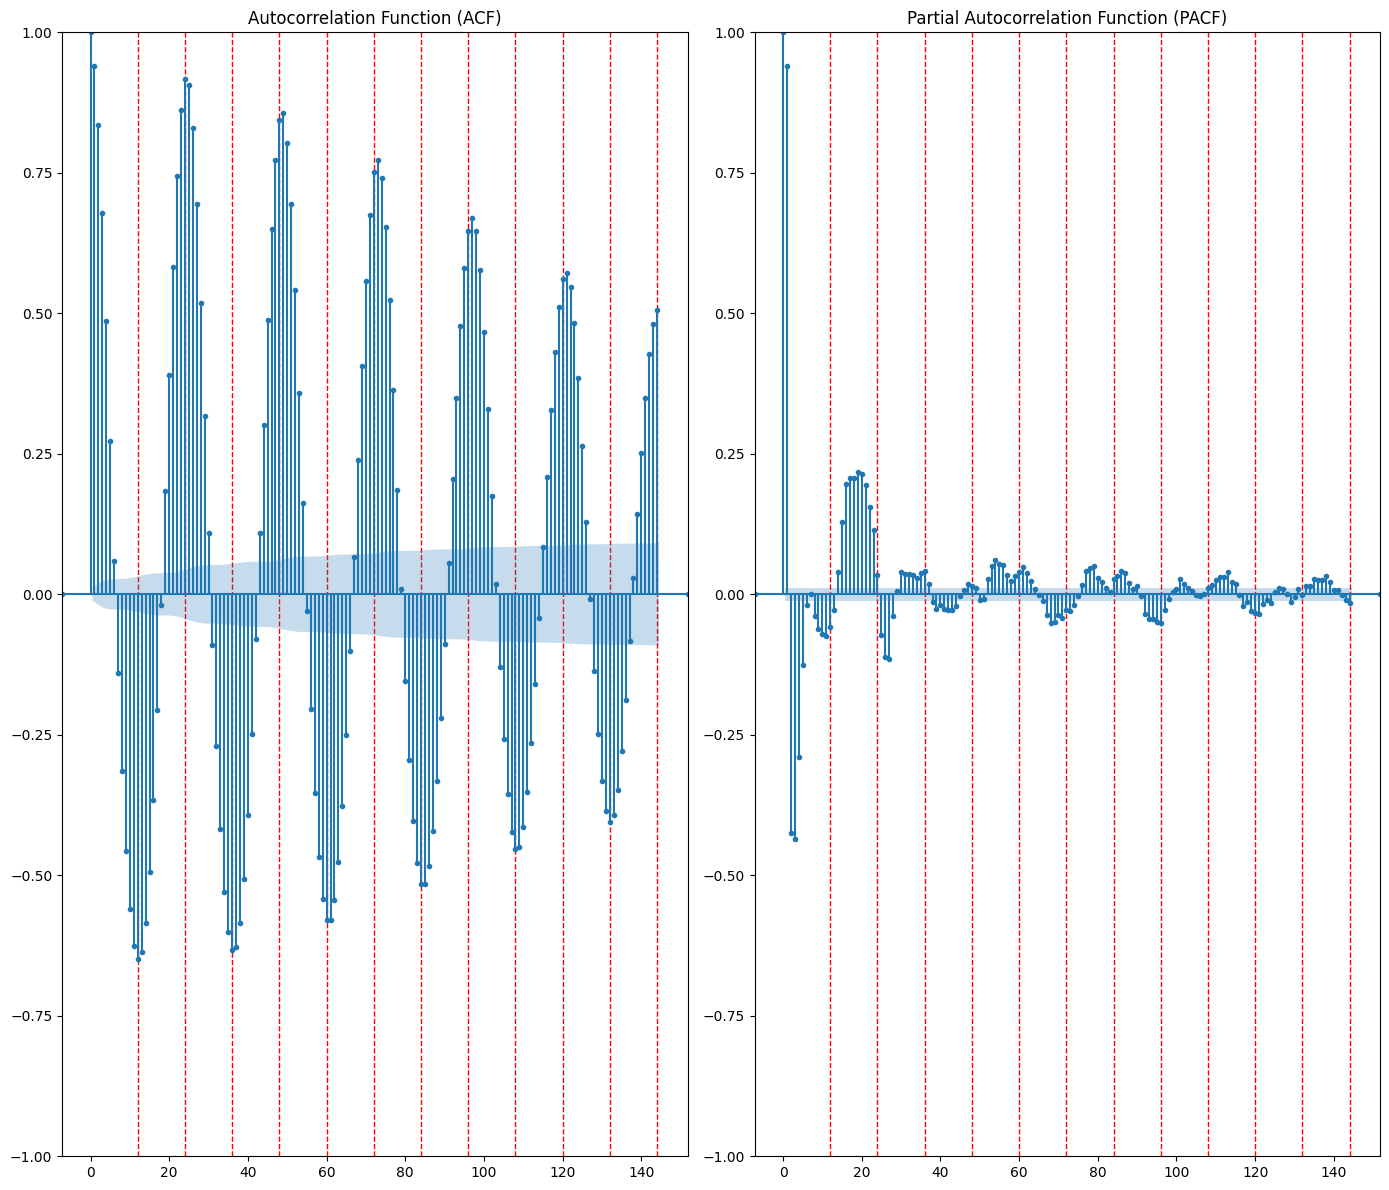

In [30]:
plot_acf_pacf(data_y_train_pow, period, 150)

# Modelling

In [ ]:
# # Define model configurations to test
# ar_configs = [
#     # AR model based on ACF PACF
#     {'name': 'ARIMA(1,0,0)', 'model_type': 'ARIMA', 'order': (1,0,0), 'seasonal_order': None, 'exog': False},

#     # SARIMA models
#     {'name': 'SARIMA(0,0,0)x(0,0,0,12)', 'model_type': 'SARIMA', 'order': (0,0,0), 'seasonal_order': (0,0,0,12), 'exog': False},

#     # ARIMAX models
#     {'name': 'ARIMAX(0,0,0)', 'model_type': 'ARIMAX', 'order': (0,0,0), 'seasonal_order': None, 'exog': True},

#     # SARIMAX models
#     {'name': 'SARIMAX(0,0,0)x(0,0,0,12)', 'model_type': 'SARIMAX', 'order': (0,0,0), 'seasonal_order': (0,0,0,12), 'exog': True},
# ]

In [ ]:
# ARIMA model based on ACF PACF (q: dies down; p: cut off at lag-6)
ar_configs = [
    {'name': 'ARIMA(1,0,0)', 'model_type': 'ARIMA', 'order': (1,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,0)', 'model_type': 'ARIMA', 'order': (2,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,0)', 'model_type': 'ARIMA', 'order': (3,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(4,0,0)', 'model_type': 'ARIMA', 'order': (4,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(5,0,0)', 'model_type': 'ARIMA', 'order': (5,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(6,0,0)', 'model_type': 'ARIMA', 'order': (6,0,0), 'seasonal_order': None, 'exog': False},
]
ar_comparison = modelling (ar_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ar_comparison


Testing ARIMA(1,0,0)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -87364.172
Date:                Wed, 28 May 2025   AIC                         174734.344
Time:                        07:07:25   BIC                         174759.237
Sample:                    10-16-2021   HQIC                        174742.336
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.4089      0.450    232.055      0.000     103.527     105.291
ar.L1          0.9406      0.002    448.617      0.000       0.93

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMA(1,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,9.2351,23.4623
1,Pasar Ikan (air),"ARIMA(2,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,8.3537,23.4397
2,Pasar Ikan (air),"ARIMA(3,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,7.5238,23.3897
3,Pasar Ikan (air),"ARIMA(4,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,7.2060,23.3124
4,Pasar Ikan (air),"ARIMA(5,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,7.1495,23.2710
5,Pasar Ikan (air),"ARIMA(6,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,7.1483,23.2621
6,Pasar Ikan (air),"ARIMA(7,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1483,23.2624


In [ ]:
# Since all the model parameters are significant to the model, we try other ar model
ar2_configs = [
    {'name': 'ARIMA(7,0,0)', 'model_type': 'ARIMA', 'order': (7,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(8,0,0)', 'model_type': 'ARIMA', 'order': (8,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(9,0,0)', 'model_type': 'ARIMA', 'order': (9,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(10,0,0)', 'model_type': 'ARIMA', 'order': (10,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(11,0,0)', 'model_type': 'ARIMA', 'order': (11,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(12,0,0)', 'model_type': 'ARIMA', 'order': (12,0,0), 'seasonal_order': None, 'exog': False},
]
ar2_comparison = modelling (ar2_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)


Testing ARIMA(7,0,0)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:                 ARIMA(7, 0, 0)   Log Likelihood              -79770.652
Date:                Wed, 28 May 2025   AIC                         159559.304
Time:                        07:13:00   BIC                         159633.982
Sample:                    10-16-2021   HQIC                        159583.278
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.4089      0.116    900.328      0.000     104.182     104.636
ar.L1          0.9915      0.003    342.174      0.000       0.98

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMA(7,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1483,23.2624
1,Pasar Ikan (air),"ARIMA(8,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1426,23.2422
2,Pasar Ikan (air),"ARIMA(9,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,7.1281,23.2085
3,Pasar Ikan (air),"ARIMA(10,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1098,23.1740
4,Pasar Ikan (air),"ARIMA(11,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,7.0894,23.1533
5,Pasar Ikan (air),"ARIMA(12,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,7.0774,23.1538


In [ ]:
# Try MA models
ma_configs = [
    {'name': 'ARIMA(0,0,1)', 'model_type': 'ARIMA', 'order': (0,0,1), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,2)', 'model_type': 'ARIMA', 'order': (0,0,2), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,3)', 'model_type': 'ARIMA', 'order': (0,0,3), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,4)', 'model_type': 'ARIMA', 'order': (0,0,4), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,5)', 'model_type': 'ARIMA', 'order': (0,0,5), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,6)', 'model_type': 'ARIMA', 'order': (0,0,6), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,7)', 'model_type': 'ARIMA', 'order': (0,0,7), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,8)', 'model_type': 'ARIMA', 'order': (0,0,8), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,9)', 'model_type': 'ARIMA', 'order': (0,0,9), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,10)', 'model_type': 'ARIMA', 'order': (0,0,10), 'seasonal_order': None, 'exog': False},
]
ma_comparison = modelling (ma_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ma_comparison


Testing ARIMA(0,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:                 ARIMA(0, 0, 1)   Log Likelihood             -104527.900
Date:                Wed, 28 May 2025   AIC                         209061.800
Time:                        08:26:26   BIC                         209086.693
Sample:                    10-16-2021   HQIC                        209069.791
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.4090      0.087   1202.501      0.000     104.239     104.579
ma.L1          0.8213      0.003    272.282      0.000       0.81

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMA(0,0,1)",Ya,0.000000,Tidak,0.001000,Tidak,16.4721,23.4850
1,Pasar Ikan (air),"ARIMA(0,0,2)",Ya,0.000000,Tidak,0.001000,Tidak,12.3285,23.4819
2,Pasar Ikan (air),"ARIMA(0,0,3)",Ya,0.000000,Tidak,0.001000,Tidak,10.3810,23.4750
3,Pasar Ikan (air),"ARIMA(0,0,4)",Ya,0.000000,Tidak,0.001000,Tidak,9.2558,23.4748
4,Pasar Ikan (air),"ARIMA(0,0,5)",Ya,0.000000,Tidak,0.001000,Tidak,8.5162,23.4669
5,Pasar Ikan (air),"ARIMA(0,0,6)",Ya,0.000000,Tidak,0.001000,Tidak,8.1222,23.4567
6,Pasar Ikan (air),"ARIMA(0,0,7)",Ya,0.000000,Tidak,0.001000,Tidak,7.8835,23.4532
7,Pasar Ikan (air),"ARIMA(0,0,8)",Ya,0.000000,Tidak,0.001000,Tidak,7.6218,23.4385
8,Pasar Ikan (air),"ARIMA(0,0,9)",Ya,0.000000,Tidak,0.001000,Tidak,7.4823,23.4276
9,Pasar Ikan (air),"ARIMA(0,0,10)",Ya,0.000000,Tidak,0.001000,Tidak,7.4217,23.4187


In [ ]:
# Try MA models
ma2_configs = [
    {'name': 'ARIMA(0,0,11)', 'model_type': 'ARIMA', 'order': (0,0,11), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,12)', 'model_type': 'ARIMA', 'order': (0,0,12), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,13)', 'model_type': 'ARIMA', 'order': (0,0,13), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,14)', 'model_type': 'ARIMA', 'order': (0,0,14), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,15)', 'model_type': 'ARIMA', 'order': (0,0,15), 'seasonal_order': None, 'exog': False},
]
ma2_comparison = modelling (ma2_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ma2_comparison


Testing ARIMA(0,0,11)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:                ARIMA(0, 0, 11)   Log Likelihood              -80734.344
Date:                Wed, 28 May 2025   AIC                         161494.689
Time:                        08:38:07   BIC                         161602.558
Sample:                    10-16-2021   HQIC                        161529.318
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.4089      0.249    418.677      0.000     103.920     104.898
ma.L1          1.0440      0.003    365.351      0.000       1.0

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMA(0,0,11)",Ya,0.000000,Tidak,0.001000,Tidak,7.3853,23.4097
1,Pasar Ikan (air),"ARIMA(0,0,12)",Ya,0.000000,Tidak,0.001000,Tidak,7.3614,23.4052
2,Pasar Ikan (air),"ARIMA(0,0,13)",Ya,0.000000,Tidak,0.001000,Tidak,7.3528,23.4025
3,Pasar Ikan (air),"ARIMA(0,0,14)",Tidak,0.000000,Tidak,0.001000,Tidak,7.3526,23.4018
4,Pasar Ikan (air),"ARIMA(0,0,15)",Tidak,0.000000,Tidak,0.001000,Tidak,7.3401,23.4110


In [ ]:
# Try ARMA models
arma_configs = [
    {'name': 'ARIMA(1,0,1)', 'model_type': 'ARIMA', 'order': (1,0,1), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,2)', 'model_type': 'ARIMA', 'order': (1,0,2), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,3)', 'model_type': 'ARIMA', 'order': (1,0,3), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,4)', 'model_type': 'ARIMA', 'order': (1,0,4), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,5)', 'model_type': 'ARIMA', 'order': (1,0,5), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,6)', 'model_type': 'ARIMA', 'order': (1,0,6), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,7)', 'model_type': 'ARIMA', 'order': (1,0,7), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,8)', 'model_type': 'ARIMA', 'order': (1,0,8), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,9)', 'model_type': 'ARIMA', 'order': (1,0,9), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,10)', 'model_type': 'ARIMA', 'order': (1,0,10), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,11)', 'model_type': 'ARIMA', 'order': (1,0,11), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,12)', 'model_type': 'ARIMA', 'order': (1,0,12), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,13)', 'model_type': 'ARIMA', 'order': (1,0,13), 'seasonal_order': None, 'exog': False},
]
arma_comparison = modelling (arma_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
arma_comparison


Testing ARIMA(1,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -85805.475
Date:                Wed, 28 May 2025   AIC                         171618.949
Time:                        09:02:41   BIC                         171652.140
Sample:                    10-16-2021   HQIC                        171629.605
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.4089      0.383    272.488      0.000     103.658     105.160
ar.L1          0.9162      0.003    359.148      0.000       0.91

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMA(1,0,1)",Ya,0.000000,Tidak,0.001000,Tidak,8.7596,23.4550
1,Pasar Ikan (air),"ARIMA(1,0,2)",Ya,0.000000,Tidak,0.001000,Tidak,8.2626,23.4511
2,Pasar Ikan (air),"ARIMA(1,0,3)",Ya,0.000000,Tidak,0.001000,Tidak,7.9071,23.4406
3,Pasar Ikan (air),"ARIMA(1,0,4)",Ya,0.000000,Tidak,0.001000,Tidak,7.7088,23.4355
4,Pasar Ikan (air),"ARIMA(1,0,5)",Ya,0.000000,Tidak,0.001000,Tidak,7.6145,23.4277
5,Pasar Ikan (air),"ARIMA(1,0,6)",Ya,0.000000,Tidak,0.001000,Tidak,7.5223,23.4189
6,Pasar Ikan (air),"ARIMA(1,0,7)",Ya,0.000000,Tidak,0.001000,Tidak,7.4476,23.4136
7,Pasar Ikan (air),"ARIMA(1,0,8)",Ya,0.000000,Tidak,0.001000,Tidak,7.4073,23.4104
8,Pasar Ikan (air),"ARIMA(1,0,9)",Ya,0.000000,Tidak,0.001000,Tidak,7.3871,23.4066
9,Pasar Ikan (air),"ARIMA(1,0,10)",Ya,0.000000,Tidak,0.001000,Tidak,7.4597,23.4277


In [ ]:
# Try ARMA models
arma2_configs = [
    {'name': 'ARIMA(2,0,1)', 'model_type': 'ARIMA', 'order': (2,0,1), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,2)', 'model_type': 'ARIMA', 'order': (2,0,2), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,3)', 'model_type': 'ARIMA', 'order': (2,0,3), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,4)', 'model_type': 'ARIMA', 'order': (2,0,4), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,5)', 'model_type': 'ARIMA', 'order': (2,0,5), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,6)', 'model_type': 'ARIMA', 'order': (2,0,6), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,7)', 'model_type': 'ARIMA', 'order': (2,0,7), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,8)', 'model_type': 'ARIMA', 'order': (2,0,8), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,9)', 'model_type': 'ARIMA', 'order': (2,0,9), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,10)', 'model_type': 'ARIMA', 'order': (2,0,10), 'seasonal_order': None, 'exog': False},
]
arma2_comparison = modelling (arma2_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
arma2_comparison


Testing ARIMA(2,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:                 ARIMA(2, 0, 1)   Log Likelihood              -80477.711
Date:                Wed, 28 May 2025   AIC                         160965.422
Time:                        09:22:31   BIC                         161006.910
Sample:                    10-16-2021   HQIC                        160978.741
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.4105      0.094   1114.025      0.000     104.227     104.594
ar.L1          1.8665      0.003    743.410      0.000       1.86

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMA(2,0,1)",Ya,0.000000,Tidak,0.001000,Tidak,7.3176,23.1850
1,Pasar Ikan (air),"ARIMA(2,0,2)",Ya,0.000000,Tidak,0.001000,Tidak,7.1606,23.2535
2,Pasar Ikan (air),"ARIMA(2,0,3)",Ya,0.000000,Tidak,0.001000,Tidak,7.1508,23.2094
3,Pasar Ikan (air),"ARIMA(2,0,4)",Ya,0.000000,Tidak,0.001000,Tidak,7.1293,23.2075
4,Pasar Ikan (air),"ARIMA(2,0,5)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1249,23.2209
5,Pasar Ikan (air),"ARIMA(2,0,6)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1247,23.2153
6,Pasar Ikan (air),"ARIMA(2,0,7)",Tidak,0.000000,Tidak,0.001000,Tidak,6.7857,20.9021
7,Pasar Ikan (air),"ARIMA(2,0,8)",Tidak,0.000000,Tidak,0.001000,Tidak,6.7388,20.4991
8,Pasar Ikan (air),"ARIMA(2,0,9)",Ya,0.000000,Tidak,0.001000,Tidak,7.2822,23.4254
9,Pasar Ikan (air),"ARIMA(2,0,10)",Ya,0.000000,Tidak,0.001000,Tidak,7.2776,23.4319


In [ ]:
# Try ARMA models
arma3_configs = [
    {'name': 'ARIMA(2,0,11)', 'model_type': 'ARIMA', 'order': (2,0,11), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,12)', 'model_type': 'ARIMA', 'order': (2,0,12), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,13)', 'model_type': 'ARIMA', 'order': (2,0,13), 'seasonal_order': None, 'exog': False}
]
arma3_comparison = modelling (arma3_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
arma3_comparison


Testing ARIMA(2,0,11)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:                ARIMA(2, 0, 11)   Log Likelihood              -80237.259
Date:                Wed, 28 May 2025   AIC                         160504.518
Time:                        09:53:59   BIC                         160628.982
Sample:                    10-16-2021   HQIC                        160544.475
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.4100      0.223    467.696      0.000     103.972     104.848
ar.L1          1.5953      0.006    246.097      0.000       1.5

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMA(2,0,11)",Ya,0.000000,Tidak,0.001000,Tidak,7.2613,23.4452
1,Pasar Ikan (air),"ARIMA(2,0,12)",Tidak,0.000000,Tidak,0.001000,Tidak,6.8694,23.0668
2,Pasar Ikan (air),"ARIMA(2,0,13)",Tidak,0.000000,Tidak,0.001000,Tidak,6.6820,22.5556


In [ ]:
# Try ARMA models
arma4_configs = [
    {'name': 'ARIMA(3,0,1)', 'model_type': 'ARIMA', 'order': (3,0,1), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,2)', 'model_type': 'ARIMA', 'order': (3,0,2), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,3)', 'model_type': 'ARIMA', 'order': (3,0,3), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,4)', 'model_type': 'ARIMA', 'order': (3,0,4), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,5)', 'model_type': 'ARIMA', 'order': (3,0,5), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,6)', 'model_type': 'ARIMA', 'order': (3,0,6), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,7)', 'model_type': 'ARIMA', 'order': (3,0,7), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,8)', 'model_type': 'ARIMA', 'order': (3,0,8), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,9)', 'model_type': 'ARIMA', 'order': (3,0,9), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,10)', 'model_type': 'ARIMA', 'order': (3,0,10), 'seasonal_order': None, 'exog': False}
]
arma4_comparison = modelling (arma4_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
arma4_comparison


Testing ARIMA(3,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:                 ARIMA(3, 0, 1)   Log Likelihood              -79830.721
Date:                Wed, 28 May 2025   AIC                         159673.443
Time:                        10:03:07   BIC                         159723.229
Sample:                    10-16-2021   HQIC                        159689.426
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.4098      0.101   1030.235      0.000     104.211     104.608
ar.L1          1.5756      0.007    221.755      0.000       1.56

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMA(3,0,1)",Ya,0.000000,Tidak,0.001000,Tidak,7.1617,23.1906
1,Pasar Ikan (air),"ARIMA(3,0,2)",Ya,0.000000,Tidak,0.001000,Tidak,7.1551,23.2266
2,Pasar Ikan (air),"ARIMA(3,0,3)",Ya,0.000000,Tidak,0.001000,Tidak,7.1377,23.2176
3,Pasar Ikan (air),"ARIMA(3,0,4)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1268,23.2187
4,Pasar Ikan (air),"ARIMA(3,0,5)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1248,23.2199
5,Pasar Ikan (air),"ARIMA(3,0,6)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1248,23.2208
6,Pasar Ikan (air),"ARIMA(3,0,7)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1247,23.2157
7,Pasar Ikan (air),"ARIMA(3,0,8)",Tidak,0.000000,Tidak,0.001000,Tidak,6.7292,21.4125
8,Pasar Ikan (air),"ARIMA(3,0,9)",Tidak,0.000000,Tidak,0.001000,Tidak,7.2854,23.4214
9,Pasar Ikan (air),"ARIMA(3,0,10)",Tidak,0.000000,Tidak,0.001000,Tidak,7.2817,23.4258


In [ ]:
# Try ARMA models
arma5_configs = [
    {'name': 'ARIMA(4,0,1)', 'model_type': 'ARIMA', 'order': (4,0,1), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(4,0,2)', 'model_type': 'ARIMA', 'order': (4,0,2), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(4,0,3)', 'model_type': 'ARIMA', 'order': (4,0,3), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(4,0,4)', 'model_type': 'ARIMA', 'order': (4,0,4), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(4,0,5)', 'model_type': 'ARIMA', 'order': (4,0,5), 'seasonal_order': None, 'exog': False},
]
arma5_comparison = modelling (arma5_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
arma5_comparison


Testing ARIMA(4,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:                 ARIMA(4, 0, 1)   Log Likelihood              -79772.331
Date:                Wed, 28 May 2025   AIC                         159558.662
Time:                        10:20:42   BIC                         159616.745
Sample:                    10-16-2021   HQIC                        159577.309
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.4097      0.110    948.981      0.000     104.194     104.625
ar.L1          1.3987      0.015     96.364      0.000       1.37

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMA(4,0,1)",Ya,0.000000,Tidak,0.001000,Tidak,7.1485,23.2343
1,Pasar Ikan (air),"ARIMA(4,0,2)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1485,23.2330
2,Pasar Ikan (air),"ARIMA(4,0,3)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1533,23.2209
3,Pasar Ikan (air),"ARIMA(4,0,4)",Ya,0.000000,Tidak,0.001000,Tidak,6.5525,25.6647
4,Pasar Ikan (air),"ARIMA(4,0,5)",Ya,0.000000,Tidak,0.001000,Tidak,6.5097,22.3463


In [ ]:
# Try ARMA models
arma6_configs = [
    {'name': 'ARIMA(4,0,6)', 'model_type': 'ARIMA', 'order': (4,0,6), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(4,0,7)', 'model_type': 'ARIMA', 'order': (4,0,7), 'seasonal_order': None, 'exog': False}
]
arma6_comparison = modelling (arma6_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
arma6_comparison


Testing ARIMA(4,0,6)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:                 ARIMA(4, 0, 6)   Log Likelihood              -79686.784
Date:                Wed, 28 May 2025   AIC                         159397.567
Time:                        10:35:03   BIC                         159497.139
Sample:                    10-16-2021   HQIC                        159429.533
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.3708      0.101   1030.284      0.000     104.172     104.569
ar.L1          0.3315      0.092      3.596      0.000       0.15

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMA(4,0,6)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1273,23.2143
1,Pasar Ikan (air),"ARIMA(4,0,7)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1244,23.2206


In [ ]:
# Try ARMA models
arma7_configs = [
    {'name': 'ARIMA(5,0,1)', 'model_type': 'ARIMA', 'order': (5,0,1), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(5,0,2)', 'model_type': 'ARIMA', 'order': (5,0,2), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(5,0,3)', 'model_type': 'ARIMA', 'order': (5,0,3), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(5,0,4)', 'model_type': 'ARIMA', 'order': (5,0,4), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(5,0,5)', 'model_type': 'ARIMA', 'order': (5,0,5), 'seasonal_order': None, 'exog': False},
]
arma7_comparison = modelling (arma7_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
arma7_comparison


Testing ARIMA(5,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:                 ARIMA(5, 0, 1)   Log Likelihood              -79770.108
Date:                Wed, 28 May 2025   AIC                         159556.216
Time:                        10:39:48   BIC                         159622.597
Sample:                    10-16-2021   HQIC                        159577.526
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.4118      0.115    908.528      0.000     104.187     104.637
ar.L1          1.1691      0.043     26.886      0.000       1.08

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMA(5,0,1)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1482,23.2580
1,Pasar Ikan (air),"ARIMA(5,0,2)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1477,23.2486
2,Pasar Ikan (air),"ARIMA(5,0,3)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1475,23.2438
3,Pasar Ikan (air),"ARIMA(5,0,4)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1221,23.2175
4,Pasar Ikan (air),"ARIMA(5,0,5)",Ya,0.000000,Tidak,0.001000,Tidak,6.6987,22.5278


In [ ]:
# Try ARMA models
arma8_configs = [
    {'name': 'ARIMA(5,0,1)', 'model_type': 'ARIMA', 'order': (5,0,1), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(5,0,2)', 'model_type': 'ARIMA', 'order': (5,0,2), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(5,0,3)', 'model_type': 'ARIMA', 'order': (5,0,3), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(5,0,4)', 'model_type': 'ARIMA', 'order': (5,0,4), 'seasonal_order': None, 'exog': False},
]
arma8_comparison = modelling (arma8_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
arma8_comparison


Testing ARIMA(5,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:                 ARIMA(5, 0, 1)   Log Likelihood              -79770.108
Date:                Wed, 28 May 2025   AIC                         159556.216
Time:                        10:53:06   BIC                         159622.597
Sample:                    10-16-2021   HQIC                        159577.526
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.4118      0.115    908.528      0.000     104.187     104.637
ar.L1          1.1691      0.043     26.886      0.000       1.08

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMA(5,0,1)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1482,23.2580
1,Pasar Ikan (air),"ARIMA(5,0,2)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1477,23.2486
2,Pasar Ikan (air),"ARIMA(5,0,3)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1475,23.2438
3,Pasar Ikan (air),"ARIMA(5,0,4)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1221,23.2175


In [ ]:
# Try ARMA models
arma9_configs = [
    {'name': 'ARIMA(6,0,1)', 'model_type': 'ARIMA', 'order': (6,0,1), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(6,0,2)', 'model_type': 'ARIMA', 'order': (6,0,2), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(6,0,3)', 'model_type': 'ARIMA', 'order': (6,0,3), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(6,0,4)', 'model_type': 'ARIMA', 'order': (6,0,4), 'seasonal_order': None, 'exog': False},
]
arma9_comparison = modelling (arma9_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
arma9_comparison


Testing ARIMA(6,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:                 ARIMA(6, 0, 1)   Log Likelihood              -79770.065
Date:                Wed, 28 May 2025   AIC                         159558.131
Time:                        10:58:57   BIC                         159632.809
Sample:                    10-16-2021   HQIC                        159582.105
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.4090      0.116    898.272      0.000     104.181     104.637
ar.L1          0.7628      0.287      2.654      0.008       0.19

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMA(6,0,1)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1482,23.2634
1,Pasar Ikan (air),"ARIMA(6,0,2)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1481,23.2636
2,Pasar Ikan (air),"ARIMA(6,0,3)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1471,23.2478
3,Pasar Ikan (air),"ARIMA(6,0,4)",Tidak,0.000000,Tidak,0.001000,Tidak,6.6868,22.8554


In [ ]:
# Try ARMA models
arma10_configs = [
    {'name': 'ARIMA(7,0,1)', 'model_type': 'ARIMA', 'order': (7,0,1), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(7,0,2)', 'model_type': 'ARIMA', 'order': (7,0,2), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(8,0,1)', 'model_type': 'ARIMA', 'order': (8,0,1), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(8,0,2)', 'model_type': 'ARIMA', 'order': (8,0,2), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(9,0,1)', 'model_type': 'ARIMA', 'order': (9,0,1), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(9,0,2)', 'model_type': 'ARIMA', 'order': (9,0,2), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(9,0,3)', 'model_type': 'ARIMA', 'order': (9,0,3), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(9,0,4)', 'model_type': 'ARIMA', 'order': (9,0,4), 'seasonal_order': None, 'exog': False},
]
arma10_comparison = modelling (arma10_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
arma10_comparison


Testing ARIMA(7,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:                 ARIMA(7, 0, 1)   Log Likelihood              -79769.982
Date:                Wed, 28 May 2025   AIC                         159559.964
Time:                        11:10:37   BIC                         159642.941
Sample:                    10-16-2021   HQIC                        159586.603
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.4090      0.117    895.749      0.000     104.181     104.637
ar.L1          0.7630      0.849      0.899      0.369      -0.90

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMA(7,0,1)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1482,23.2646
1,Pasar Ikan (air),"ARIMA(7,0,2)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1480,23.2671
2,Pasar Ikan (air),"ARIMA(8,0,1)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1169,23.1821
3,Pasar Ikan (air),"ARIMA(8,0,2)",Error,Error,Error,Error,Error,Error,Error
4,Pasar Ikan (air),"ARIMA(9,0,1)",Ya,0.000000,Tidak,0.001000,Tidak,7.1027,23.1661
5,Pasar Ikan (air),"ARIMA(9,0,2)",Tidak,0.000000,Tidak,0.001000,Tidak,6.6358,22.4653
6,Pasar Ikan (air),"ARIMA(9,0,3)",Ya,0.000000,Tidak,0.001000,Tidak,6.6139,29.8338
7,Pasar Ikan (air),"ARIMA(9,0,4)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1436,23.2644


In [ ]:
# Add x to AR model that have all parameters significant
arx_configs = [
    {'name': 'ARIMAX(1,0,0)', 'model_type': 'ARIMA', 'order': (1,0,0), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(2,0,0)', 'model_type': 'ARIMA', 'order': (2,0,0), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(3,0,0)', 'model_type': 'ARIMA', 'order': (3,0,0), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(4,0,0)', 'model_type': 'ARIMA', 'order': (4,0,0), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(5,0,0)', 'model_type': 'ARIMA', 'order': (5,0,0), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(6,0,0)', 'model_type': 'ARIMA', 'order': (6,0,0), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(9,0,0)', 'model_type': 'ARIMA', 'order': (9,0,0), 'seasonal_order': None, 'exog': True},
]
arx_comparison = modelling (arx_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
arx_comparison


Testing ARIMA(1,0,0)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -87804.748
Date:                Wed, 28 May 2025   AIC                         175621.495
Time:                        07:21:59   BIC                         175671.281
Sample:                    10-16-2021   HQIC                        175637.478
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Gerimis          -0.2230      0.132     -1.683      0.092      -0.483       0.037
Hujan             0.0312      0.198      0.157      0.87

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMA(1,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,9.4132,107.9941
1,Pasar Ikan (air),"ARIMA(2,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,8.6949,113.1107
2,Pasar Ikan (air),"ARIMA(3,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,8.1874,Error
3,Pasar Ikan (air),"ARIMA(4,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,17.4488,159.2198
4,Pasar Ikan (air),"ARIMA(5,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,23.6629,104.6654
5,Pasar Ikan (air),"ARIMA(6,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,17.8586,154.1775
6,Pasar Ikan (air),"ARIMA(9,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,25.9109,168.4610


In [ ]:
compare = pd.concat([ar_comparison,
                     ar2_comparison,
                     ma_comparison,
                     ma2_comparison,
                     arma_comparison,
                     arma2_comparison,
                     arma3_comparison,
                     arma4_comparison,
                     arma5_comparison,
                     arma6_comparison,
                     arma7_comparison,
                     arma8_comparison,
                     arma9_comparison,
                     arma10_comparison,
                     arx_comparison
                     ])
compare
compare.to_csv(f'model_comparison_{data_y_train.name}_results.csv')

In [ ]:
compare = pd.read_csv(f'model_comparison_{data_y_train.name}_results.csv', index_col=0)
compare

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMA(1,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,9.2351,23.4623
1,Pasar Ikan (air),"ARIMA(2,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,8.3537,23.4397
2,Pasar Ikan (air),"ARIMA(3,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,7.5238,23.3897
3,Pasar Ikan (air),"ARIMA(4,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,7.2060,23.3124
4,Pasar Ikan (air),"ARIMA(5,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,7.1495,23.2710
...,...,...,...,...,...,...,...,...,...
2,Pasar Ikan (air),"ARIMAX(3,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,8.1874,Error
3,Pasar Ikan (air),"ARIMAX(4,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,17.4488,159.2198
4,Pasar Ikan (air),"ARIMAX(5,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,23.6629,104.6654
5,Pasar Ikan (air),"ARIMAX(6,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,17.8586,154.1775


In [ ]:
# Add x to all MA and models that have all parameters significant
max_configs = [
    {'name': 'ARIMAX(0,0,1)', 'model_type': 'ARIMA', 'order': (0,0,1), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(0,0,2)', 'model_type': 'ARIMA', 'order': (0,0,2), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(0,0,3)', 'model_type': 'ARIMA', 'order': (0,0,3), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(0,0,4)', 'model_type': 'ARIMA', 'order': (0,0,4), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(0,0,5)', 'model_type': 'ARIMA', 'order': (0,0,5), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(0,0,6)', 'model_type': 'ARIMA', 'order': (0,0,6), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(0,0,7)', 'model_type': 'ARIMA', 'order': (0,0,7), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(0,0,8)', 'model_type': 'ARIMA', 'order': (0,0,8), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(0,0,9)', 'model_type': 'ARIMA', 'order': (0,0,9), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(0,0,10)', 'model_type': 'ARIMA', 'order': (0,0,10), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(0,0,11)', 'model_type': 'ARIMA', 'order': (0,0,11), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(0,0,12)', 'model_type': 'ARIMA', 'order': (0,0,12), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(0,0,13)', 'model_type': 'ARIMA', 'order': (0,0,13), 'seasonal_order': None, 'exog': True}
]
max_comparison = modelling (max_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
max_comparison


Testing ARIMAX(0,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:               SARIMAX(0, 0, 1)   Log Likelihood             -159741.729
Date:                Wed, 28 May 2025   AIC                         319495.459
Time:                        22:58:43   BIC                         319545.245
Sample:                    10-16-2021   HQIC                        319511.442
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Gerimis          31.2961      1.481     21.139      0.000      28.394      34.198
Hujan            32.0689      1.977     16.220      0.0

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMAX(0,0,1)",Ya,0.000000,Tidak,0.001000,Tidak,nan,176.3607
1,Pasar Ikan (air),"ARIMAX(0,0,2)",Ya,0.000000,Tidak,0.001000,Tidak,nan,179.6389
2,Pasar Ikan (air),"ARIMAX(0,0,3)",Ya,0.000000,Tidak,0.001000,Tidak,nan,177.0451
3,Pasar Ikan (air),"ARIMAX(0,0,4)",Ya,0.000000,Tidak,0.001000,Tidak,nan,176.3577
4,Pasar Ikan (air),"ARIMAX(0,0,5)",Ya,0.000000,Tidak,0.001000,Tidak,nan,177.1587
5,Pasar Ikan (air),"ARIMAX(0,0,6)",Ya,0.000000,Tidak,0.001000,Tidak,nan,177.4562
6,Pasar Ikan (air),"ARIMAX(0,0,7)",Ya,0.000000,Tidak,0.001000,Tidak,nan,178.3676
7,Pasar Ikan (air),"ARIMAX(0,0,8)",Ya,0.000000,Tidak,0.001000,Tidak,nan,178.1756
8,Pasar Ikan (air),"ARIMAX(0,0,9)",Ya,0.000000,Tidak,0.001000,Tidak,nan,177.0176
9,Pasar Ikan (air),"ARIMAX(0,0,10)",Ya,0.000000,Tidak,0.001000,Tidak,nan,178.7986


In [ ]:
# Add x to all ARMA and models that have all parameters significant
armax_configs = [
    {'name': 'ARIMAX(1,0,1)', 'model_type': 'ARIMA', 'order': (1,0,1), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,2)', 'model_type': 'ARIMA', 'order': (1,0,2), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,3)', 'model_type': 'ARIMA', 'order': (1,0,3), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,4)', 'model_type': 'ARIMA', 'order': (1,0,4), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,5)', 'model_type': 'ARIMA', 'order': (1,0,5), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,6)', 'model_type': 'ARIMA', 'order': (1,0,6), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,7)', 'model_type': 'ARIMA', 'order': (1,0,7), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,8)', 'model_type': 'ARIMA', 'order': (1,0,8), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,9)', 'model_type': 'ARIMA', 'order': (1,0,9), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,10)', 'model_type': 'ARIMA', 'order': (1,0,10), 'seasonal_order': None, 'exog': True},
]
armax_comparison = modelling (armax_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
armax_comparison


Testing ARIMAX(1,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -86430.199
Date:                Wed, 28 May 2025   AIC                         172874.397
Time:                        23:29:58   BIC                         172932.481
Sample:                    10-16-2021   HQIC                        172893.044
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Gerimis          -0.1468      0.110     -1.330      0.183      -0.363       0.069
Hujan             0.0754      0.166      0.454      0.6

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMAX(1,0,1)",Tidak,0.000000,Tidak,0.001000,Tidak,8.9877,25.6523
1,Pasar Ikan (air),"ARIMAX(1,0,2)",Ya,0.000000,Tidak,0.001000,Tidak,8.8200,Error
2,Pasar Ikan (air),"ARIMAX(1,0,3)",Tidak,0.000000,Tidak,0.001000,Tidak,19.4088,113.7878
3,Pasar Ikan (air),"ARIMAX(1,0,4)",Ya,0.000000,Tidak,0.001000,Tidak,19.9529,125.1812
4,Pasar Ikan (air),"ARIMAX(1,0,5)",Ya,0.000000,Tidak,0.001000,Tidak,nan,62.3048
5,Pasar Ikan (air),"ARIMAX(1,0,6)",Ya,0.000000,Tidak,0.001000,Tidak,25.7645,52.1007
6,Pasar Ikan (air),"ARIMAX(1,0,7)",Ya,0.000000,Tidak,0.001000,Tidak,25.7257,94.8522
7,Pasar Ikan (air),"ARIMAX(1,0,8)",Tidak,0.000000,Tidak,0.001000,Tidak,35.0652,52.1963
8,Pasar Ikan (air),"ARIMAX(1,0,9)",Ya,0.000000,Tidak,0.001000,Tidak,39.7637,63.3370
9,Pasar Ikan (air),"ARIMAX(1,0,10)",Ya,0.000011,Tidak,0.001000,Tidak,39.8962,63.5054


In [ ]:
# Add x to all ARMA and models that have all parameters significant
armax2_configs = [
    {'name': 'ARIMAX(2,0,1)', 'model_type': 'ARIMA', 'order': (2,0,1), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(2,0,2)', 'model_type': 'ARIMA', 'order': (2,0,2), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(2,0,3)', 'model_type': 'ARIMA', 'order': (2,0,3), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(2,0,4)', 'model_type': 'ARIMA', 'order': (2,0,4), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(2,0,9)', 'model_type': 'ARIMA', 'order': (2,0,9), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(2,0,10)', 'model_type': 'ARIMA', 'order': (2,0,10), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(2,0,11)', 'model_type': 'ARIMA', 'order': (2,0,11), 'seasonal_order': None, 'exog': True}
]
armax2_comparison = modelling (armax2_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
armax2_comparison


Testing ARIMAX(2,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:               SARIMAX(2, 0, 1)   Log Likelihood              -84258.208
Date:                Wed, 28 May 2025   AIC                         168532.416
Time:                        23:51:00   BIC                         168598.797
Sample:                    10-16-2021   HQIC                        168553.727
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Gerimis          -0.1256      0.096     -1.316      0.188      -0.313       0.062
Hujan             0.0674      0.145      0.465      0.6

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMAX(2,0,1)",Tidak,0.000000,Tidak,0.001000,Tidak,8.3555,62.1829
1,Pasar Ikan (air),"ARIMAX(2,0,2)",Tidak,0.000000,Tidak,0.001000,Tidak,12.6352,24.3006
2,Pasar Ikan (air),"ARIMAX(2,0,3)",Tidak,0.000000,Tidak,0.001000,Tidak,8.8628,27.8077
3,Pasar Ikan (air),"ARIMAX(2,0,4)",Tidak,0.000000,Tidak,0.001000,Tidak,26.2932,36.8946
4,Pasar Ikan (air),"ARIMAX(2,0,9)",Ya,0.000000,Tidak,0.001000,Tidak,nan,70.2039
5,Pasar Ikan (air),"ARIMAX(2,0,10)",Ya,0.000000,Tidak,0.001000,Tidak,34.9453,51.1028
6,Pasar Ikan (air),"ARIMAX(2,0,11)",Ya,0.000000,Tidak,0.001000,Tidak,nan,66.9014


In [ ]:
# Add x to all ARMA and models that have all parameters significant
armax3_configs = [
    {'name': 'ARIMAX(3,0,1)', 'model_type': 'ARIMA', 'order': (3,0,1), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(3,0,2)', 'model_type': 'ARIMA', 'order': (3,0,2), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(3,0,3)', 'model_type': 'ARIMA', 'order': (3,0,3), 'seasonal_order': None, 'exog': True},
]
armax3_comparison = modelling (armax3_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
armax3_comparison


Testing ARIMAX(3,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:               SARIMAX(3, 0, 1)   Log Likelihood             -112120.060
Date:                Thu, 29 May 2025   AIC                         224258.120
Time:                        00:18:21   BIC                         224332.799
Sample:                    10-16-2021   HQIC                        224282.095
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Gerimis          12.4676      0.285     43.723      0.000      11.909      13.027
Hujan            65.1307      0.449    144.898      0.0

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMAX(3,0,1)",Ya,0.000000,Tidak,0.001000,Tidak,20.7037,Error
1,Pasar Ikan (air),"ARIMAX(3,0,2)",Ya,0.000000,Tidak,0.001000,Tidak,nan,Error
2,Pasar Ikan (air),"ARIMAX(3,0,3)",Ya,0.000000,Tidak,0.001000,Tidak,17.2508,27.5023


In [ ]:
# Add x to all ARMA and models that have all parameters significant
armax4_configs = [
    {'name': 'ARIMAX(4,0,1)', 'model_type': 'ARIMA', 'order': (4,0,1), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(4,0,4)', 'model_type': 'ARIMA', 'order': (4,0,4), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(4,0,5)', 'model_type': 'ARIMA', 'order': (4,0,5), 'seasonal_order': None, 'exog': True}
]
armax4_comparison = modelling (armax4_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
armax4_comparison


Testing ARIMAX(4,0,1)
Fitting model...
Error fitting ARIMAX(4,0,1): LU decomposition error.
Error cleanup: 0 objects collected

Testing ARIMAX(4,0,4)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:               SARIMAX(4, 0, 4)   Log Likelihood             -137614.907
Date:                Thu, 29 May 2025   AIC                         275255.815
Time:                        00:26:24   BIC                         275363.684
Sample:                    10-16-2021   HQIC                        275290.445
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Gerimis  

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMAX(4,0,1)",Error,Error,Error,Error,Error,Error,Error
1,Pasar Ikan (air),"ARIMAX(4,0,4)",Ya,0.000000,Tidak,0.001000,Tidak,nan,77.7257
2,Pasar Ikan (air),"ARIMAX(4,0,5)",Ya,0.000000,Tidak,0.001000,Tidak,nan,Error


In [ ]:
# Add x to all ARMA and models that have all parameters significant
armax5_configs = [
    {'name': 'ARIMAX(5,0,5)', 'model_type': 'ARIMA', 'order': (5,0,5), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(9,0,1)', 'model_type': 'ARIMA', 'order': (9,0,1), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(9,0,3)', 'model_type': 'ARIMA', 'order': (9,0,3), 'seasonal_order': None, 'exog': True}
]
armax5_comparison = modelling (armax5_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
armax5_comparison


Testing ARIMAX(5,0,5)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:               SARIMAX(5, 0, 5)   Log Likelihood                   0.000
Date:                Thu, 29 May 2025   AIC                             30.000
Time:                        00:30:44   BIC                            154.464
Sample:                    10-16-2021   HQIC                            69.957
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Gerimis        -239.3873         -0        inf      0.000    -239.387    -239.387
Hujan           -14.5674         -0        inf      0.0

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMAX(5,0,5)",Ya,0.000000,Tidak,0.001000,Tidak,nan,Error
1,Pasar Ikan (air),"ARIMAX(9,0,1)",Ya,0.000000,Tidak,0.001000,Tidak,nan,Error
2,Pasar Ikan (air),"ARIMAX(9,0,3)",Ya,0.000000,Tidak,0.001000,Tidak,nan,66.0514


In [ ]:
# Seasonal AR model with seasonal order (1,0,0)
sar_configs = [
    {'name': 'SARIMA(1,0,0)x(1,0,0,12)', 'model_type': 'SARIMA', 'order': (1,0,0), 'seasonal_order': (1,0,0,12), 'exog': False},
    {'name': 'SARIMA(2,0,0)x(1,0,0,12)', 'model_type': 'SARIMA', 'order': (2,0,0), 'seasonal_order': (1,0,0,12), 'exog': False},
    {'name': 'SARIMA(3,0,0)x(1,0,0,12)', 'model_type': 'SARIMA', 'order': (3,0,0), 'seasonal_order': (1,0,0,12), 'exog': False},
    {'name': 'SARIMA(4,0,0)x(1,0,0,12)', 'model_type': 'SARIMA', 'order': (4,0,0), 'seasonal_order': (1,0,0,12), 'exog': False},
    {'name': 'SARIMA(5,0,0)x(1,0,0,12)', 'model_type': 'SARIMA', 'order': (5,0,0), 'seasonal_order': (1,0,0,12), 'exog': False},
    {'name': 'SARIMA(6,0,0)x(1,0,0,12)', 'model_type': 'SARIMA', 'order': (6,0,0), 'seasonal_order': (1,0,0,12), 'exog': False},
]
sar_comparison = modelling (sar_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
sar_comparison


Testing SARIMA(1,0,0)x(1,0,0,12)
Fitting model...
Model fitted successfully!
                                     SARIMAX Results                                      
Dep. Variable:                   Pasar Ikan (air)   No. Observations:                29662
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood              -86182.632
Date:                            Thu, 29 May 2025   AIC                         172371.264
Time:                                    00:44:16   BIC                         172396.157
Sample:                                10-16-2021   HQIC                        172379.256
                                     - 03-04-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9995      0.000   5

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"SARIMA(1,0,0)x(1,0,0,12)",Ya,0.000000,Tidak,0.001000,Tidak,8.9180,72.8087
1,Pasar Ikan (air),"SARIMA(2,0,0)x(1,0,0,12)",Ya,0.000000,Tidak,0.001000,Tidak,8.5912,119.6487
2,Pasar Ikan (air),"SARIMA(3,0,0)x(1,0,0,12)",Ya,0.000000,Tidak,0.001000,Tidak,8.1702,161.4248
3,Pasar Ikan (air),"SARIMA(4,0,0)x(1,0,0,12)",Ya,0.000000,Tidak,0.001000,Tidak,8.1351,170.3291
4,Pasar Ikan (air),"SARIMA(5,0,0)x(1,0,0,12)",Ya,0.000000,Tidak,0.001000,Tidak,8.0862,165.6433
5,Pasar Ikan (air),"SARIMA(6,0,0)x(1,0,0,12)",Ya,0.000000,Tidak,0.001000,Tidak,7.9346,155.2870


In [ ]:
# Seasonal AR model with seasonal order (1,0,0)
sar2_configs = [
    {'name': 'SARIMA(7,0,0)x(1,0,0,12)', 'model_type': 'SARIMA', 'order': (7,0,0), 'seasonal_order': (1,0,0,12), 'exog': False},
    {'name': 'SARIMA(8,0,0)x(1,0,0,12)', 'model_type': 'SARIMA', 'order': (8,0,0), 'seasonal_order': (1,0,0,12), 'exog': False},
    {'name': 'SARIMA(9,0,0)x(1,0,0,12)', 'model_type': 'SARIMA', 'order': (9,0,0), 'seasonal_order': (1,0,0,12), 'exog': False}
]
sar2_comparison = modelling (sar2_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
sar2_comparison


Testing SARIMA(7,0,0)x(1,0,0,12)
Fitting model...
Model fitted successfully!
                                     SARIMAX Results                                      
Dep. Variable:                   Pasar Ikan (air)   No. Observations:                29662
Model:             SARIMAX(7, 0, 0)x(1, 0, 0, 12)   Log Likelihood              -82222.141
Date:                            Thu, 29 May 2025   AIC                         164462.283
Time:                                    01:02:44   BIC                         164536.961
Sample:                                10-16-2021   HQIC                        164486.257
                                     - 03-04-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1681      0.003    

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"SARIMA(7,0,0)x(1,0,0,12)",Ya,0.000000,Tidak,0.001000,Tidak,7.8116,142.1931
1,Pasar Ikan (air),"SARIMA(8,0,0)x(1,0,0,12)",Tidak,0.000000,Tidak,0.001000,Tidak,7.7598,132.4310
2,Pasar Ikan (air),"SARIMA(9,0,0)x(1,0,0,12)",Tidak,0.000000,Tidak,0.001000,Tidak,7.7297,124.2153


In [ ]:
# Seasonal AR model with seasonal order (2,0,0)
sar2_configs = [
    {'name': 'SARIMA(1,0,0)x(2,0,0,12)', 'model_type': 'SARIMA', 'order': (1,0,0), 'seasonal_order': (2,0,0,12), 'exog': False},
    {'name': 'SARIMA(2,0,0)x(2,0,0,12)', 'model_type': 'SARIMA', 'order': (2,0,0), 'seasonal_order': (2,0,0,12), 'exog': False},
    {'name': 'SARIMA(3,0,0)x(2,0,0,12)', 'model_type': 'SARIMA', 'order': (3,0,0), 'seasonal_order': (2,0,0,12), 'exog': False},
    {'name': 'SARIMA(4,0,0)x(2,0,0,12)', 'model_type': 'SARIMA', 'order': (4,0,0), 'seasonal_order': (2,0,0,12), 'exog': False},
    {'name': 'SARIMA(5,0,0)x(2,0,0,12)', 'model_type': 'SARIMA', 'order': (5,0,0), 'seasonal_order': (2,0,0,12), 'exog': False},
    {'name': 'SARIMA(6,0,0)x(2,0,0,12)', 'model_type': 'SARIMA', 'order': (6,0,0), 'seasonal_order': (2,0,0,12), 'exog': False},
    {'name': 'SARIMA(7,0,0)x(2,0,0,12)', 'model_type': 'SARIMA', 'order': (7,0,0), 'seasonal_order': (2,0,0,12), 'exog': False}
]
sar2_comparison = modelling (sar2_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
sar2_comparison


Testing SARIMA(1,0,0)x(2,0,0,12)
Fitting model...
Model fitted successfully!
                                     SARIMAX Results                                      
Dep. Variable:                   Pasar Ikan (air)   No. Observations:                29662
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 12)   Log Likelihood              -81482.158
Date:                            Thu, 29 May 2025   AIC                         162972.315
Time:                                    01:08:58   BIC                         163005.506
Sample:                                10-16-2021   HQIC                        162982.970
                                     - 03-04-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9990      0.000   3

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"SARIMA(1,0,0)x(2,0,0,12)",Ya,0.000000,Tidak,0.001000,Tidak,7.6205,105.8598
1,Pasar Ikan (air),"SARIMA(2,0,0)x(2,0,0,12)",Ya,0.000000,Tidak,0.001000,Tidak,7.4754,77.5388
2,Pasar Ikan (air),"SARIMA(3,0,0)x(2,0,0,12)",Ya,0.000000,Tidak,0.001000,Tidak,7.4750,75.7672
3,Pasar Ikan (air),"SARIMA(4,0,0)x(2,0,0,12)",Ya,0.000000,Tidak,0.001000,Tidak,7.4629,86.7181
4,Pasar Ikan (air),"SARIMA(5,0,0)x(2,0,0,12)",Tidak,0.000000,Tidak,0.001000,Tidak,7.4625,88.0359
5,Pasar Ikan (air),"SARIMA(6,0,0)x(2,0,0,12)",Ya,0.000000,Tidak,0.001000,Tidak,7.4461,81.6269
6,Pasar Ikan (air),"SARIMA(7,0,0)x(2,0,0,12)",Ya,0.000000,Tidak,0.001000,Tidak,7.3901,70.0972


In [ ]:
# Seasonal AR model with seasonal order (3,0,0)
sar3_configs = [
    {'name': 'SARIMA(1,0,0)x(3,0,0,12)', 'model_type': 'SARIMA', 'order': (1,0,0), 'seasonal_order': (3,0,0,12), 'exog': False},
    {'name': 'SARIMA(2,0,0)x(3,0,0,12)', 'model_type': 'SARIMA', 'order': (2,0,0), 'seasonal_order': (3,0,0,12), 'exog': False},
    {'name': 'SARIMA(3,0,0)x(3,0,0,12)', 'model_type': 'SARIMA', 'order': (3,0,0), 'seasonal_order': (3,0,0,12), 'exog': False},
    {'name': 'SARIMA(4,0,0)x(3,0,0,12)', 'model_type': 'SARIMA', 'order': (4,0,0), 'seasonal_order': (3,0,0,12), 'exog': False},
    {'name': 'SARIMA(5,0,0)x(3,0,0,12)', 'model_type': 'SARIMA', 'order': (5,0,0), 'seasonal_order': (3,0,0,12), 'exog': False},
    {'name': 'SARIMA(6,0,0)x(3,0,0,12)', 'model_type': 'SARIMA', 'order': (6,0,0), 'seasonal_order': (3,0,0,12), 'exog': False},
    {'name': 'SARIMA(7,0,0)x(3,0,0,12)', 'model_type': 'SARIMA', 'order': (7,0,0), 'seasonal_order': (3,0,0,12), 'exog': False}
]
sar3_comparison = modelling (sar3_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
sar3_comparison


Testing SARIMA(1,0,0)x(3,0,0,12)
Fitting model...
Model fitted successfully!
                                     SARIMAX Results                                      
Dep. Variable:                   Pasar Ikan (air)   No. Observations:                29662
Model:             SARIMAX(1, 0, 0)x(3, 0, 0, 12)   Log Likelihood              -81338.743
Date:                            Thu, 29 May 2025   AIC                         162687.485
Time:                                    01:27:23   BIC                         162728.973
Sample:                                10-16-2021   HQIC                        162700.804
                                     - 03-04-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9990      0.000   3

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"SARIMA(1,0,0)x(3,0,0,12)",Ya,0.000000,Tidak,0.001000,Tidak,7.5856,106.8755
1,Pasar Ikan (air),"SARIMA(2,0,0)x(3,0,0,12)",Ya,0.000000,Tidak,0.001000,Tidak,7.4508,79.1297
2,Pasar Ikan (air),"SARIMA(3,0,0)x(3,0,0,12)",Tidak,0.000000,Tidak,0.001000,Tidak,7.4508,78.5442
3,Pasar Ikan (air),"SARIMA(4,0,0)x(3,0,0,12)",Ya,0.000000,Tidak,0.001000,Tidak,7.4368,89.5299
4,Pasar Ikan (air),"SARIMA(5,0,0)x(3,0,0,12)",Tidak,0.000000,Tidak,0.001000,Tidak,7.4367,90.5734
5,Pasar Ikan (air),"SARIMA(6,0,0)x(3,0,0,12)",Ya,0.000000,Tidak,0.001000,Tidak,7.4139,83.3502
6,Pasar Ikan (air),"SARIMA(7,0,0)x(3,0,0,12)",Tidak,0.000000,Tidak,0.001000,Tidak,7.3401,71.2241


In [3]:
# Seasonal AR model with seasonal order (8,0,0)
sar4_configs = [
    {'name': 'SARIMA(1,0,0)x(8,0,0,12)', 'model_type': 'SARIMA', 'order': (1,0,0), 'seasonal_order': (8,0,0,12), 'exog': False},
    # {'name': 'SARIMA(2,0,0)x(8,0,0,12)', 'model_type': 'SARIMA', 'order': (2,0,0), 'seasonal_order': (8,0,0,12), 'exog': False},
    # {'name': 'SARIMA(3,0,0)x(8,0,0,12)', 'model_type': 'SARIMA', 'order': (3,0,0), 'seasonal_order': (8,0,0,12), 'exog': False},
    # {'name': 'SARIMA(4,0,0)x(8,0,0,12)', 'model_type': 'SARIMA', 'order': (4,0,0), 'seasonal_order': (8,0,0,12), 'exog': False},
    # {'name': 'SARIMA(5,0,0)x(8,0,0,12)', 'model_type': 'SARIMA', 'order': (5,0,0), 'seasonal_order': (8,0,0,12), 'exog': False},
    # {'name': 'SARIMA(6,0,0)x(8,0,0,12)', 'model_type': 'SARIMA', 'order': (6,0,0), 'seasonal_order': (8,0,0,12), 'exog': False},
    # {'name': 'SARIMA(7,0,0)x(8,0,0,12)', 'model_type': 'SARIMA', 'order': (7,0,0), 'seasonal_order': (8,0,0,12), 'exog': False}
]
sar4_comparison = modelling (sar4_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)


NameError: name 'modelling' is not defined

In [ ]:
# ARIMA model based on ACF PACF (q: dies down; p: cut off at lag-6)
ar_configs = [
    {'name': 'ARIMA(1,0,0)', 'model_type': 'ARIMA', 'order': (1,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,0)', 'model_type': 'ARIMA', 'order': (2,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,0)', 'model_type': 'ARIMA', 'order': (3,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(4,0,0)', 'model_type': 'ARIMA', 'order': (4,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(5,0,0)', 'model_type': 'ARIMA', 'order': (5,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(6,0,0)', 'model_type': 'ARIMA', 'order': (6,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(7,0,0)', 'model_type': 'ARIMA', 'order': (7,0,0), 'seasonal_order': None, 'exog': False}
]
ar_comparison = modelling (ar_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ar_comparison


Testing ARIMA(1,0,0)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -87364.172
Date:                Tue, 27 May 2025   AIC                         174734.344
Time:                        03:53:17   BIC                         174759.237
Sample:                    10-16-2021   HQIC                        174742.336
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.4089      0.450    232.055      0.000     103.527     105.291
ar.L1          0.9406      0.002    448.617      0.000       0.93

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMA(1,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,9.2351,23.4623
1,Pasar Ikan (air),"ARIMA(2,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,8.3537,23.4397
2,Pasar Ikan (air),"ARIMA(3,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,7.5238,23.3897
3,Pasar Ikan (air),"ARIMA(4,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,7.2060,23.3124
4,Pasar Ikan (air),"ARIMA(5,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,7.1495,23.2710
5,Pasar Ikan (air),"ARIMA(6,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,7.1483,23.2621
6,Pasar Ikan (air),"ARIMA(7,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1483,23.2624


In [ ]:
# Create comparison table
print(f"\n{'='*100}")
print("MODEL COMPARISON TABLE")
print(f"{'='*100}")

comparison_df = pd.DataFrame(results_list)
print(comparison_df.to_string(index=False))

# Save to CSV (optional)
# comparison_df.to_csv('model_comparison_results.csv', index=False)

print(f"\n{'='*100}")
print("ANALYSIS COMPLETE")
print(f"{'='*100}")

# Find best models based on different criteria
print("\nBEST MODELS ANALYSIS:")
print("-" * 50)

# Filter only successful models (no errors)
successful_models = comparison_df[
    (comparison_df['RMSE Training'] != 'Error') &
    (comparison_df['RMSE Testing'] != 'Error')
].copy()

if not successful_models.empty:
    # Convert RMSE columns to numeric
    successful_models['RMSE_Train_Numeric'] = pd.to_numeric(successful_models['RMSE Training'])
    successful_models['RMSE_Test_Numeric'] = pd.to_numeric(successful_models['RMSE Testing'])

    # Best training RMSE
    best_train = successful_models.loc[successful_models['RMSE_Train_Numeric'].idxmin()]
    print(f"Best Training RMSE: {best_train['Model']} (RMSE: {best_train['RMSE Training']})")

    # Best testing RMSE
    best_test = successful_models.loc[successful_models['RMSE_Test_Numeric'].idxmin()]
    print(f"Best Testing RMSE: {best_test['Model']} (RMSE: {best_test['RMSE Testing']})")

    # Models with all assumptions met
    good_models = successful_models[
        (successful_models['Semua Variabel Signifikan'] == 'Ya') &
        (successful_models['White Noise?'] == 'Ya') &
        (successful_models['Distribusi Normal?'] == 'Ya')
    ]

    if not good_models.empty:
        print(f"\nModels meeting all statistical assumptions:")
        for _, model in good_models.iterrows():
            print(f"- {model['Model']}")

        # Best among good models
        best_good = good_models.loc[good_models['RMSE_Test_Numeric'].idxmin()]
        print(f"\nBest model meeting all assumptions: {best_good['Model']} (Test RMSE: {best_good['RMSE Testing']})")
    else:
        print("\nNo models meet all statistical assumptions.")
else:
    print("No successful models to analyze.")